# Introduction
According to this discussion (https://www.kaggle.com/c/stanford-covid-vaccine/discussion/182021#1006800),

>The bpps are numpy arrays we pre-calculated for each sequence. hidehisaarai1213 is right; they're matrices of base pair probabilities, calculated using a recently developed algorithm in our lab.
What you use them for is totally up to you. Biophysically speaking, this matrix gives the probability that each pair of nucleotides in the RNA forms a base pair (given a particular model of RNA folding). You've probably already seen the structural features: imagine that this matrix describes the whole distribution from which one could sample more structures.
At the simplest level -- it's a symmetric square matrix with the same length as the sequence, so you can get N more features out of it, if you want them. Each column and each row should sum to one (up to rounding error), but more than one entry in each column/row will be nonzero -- usually somewhere between 1-5 entries.
Feel free to use them or ignore them based on your own judgement; we pre-generated them because it would take a little specialized knowledge to do so, as well as a little time (a bit under a second for each sequence). At the same time, feel free to generate and share other biophysically inspired features of your own, if you suspect they might be helpful!

It seems that many public kernel do　not use bpps at least explicitly. Here I try to include it as a simple feature and found that it has relatively high feature importance in a tree-based model, at least among other included features. This experiment suggests that using bpps somehow in your model may improve your performance.

# Libraries

In [1]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from pathlib import Path
from tqdm import tqdm

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score

# model
import lightgbm as lgb

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.filterwarnings('ignore')

# CONFIG

In [2]:
SEED = 42
NFOLD = 7
SHIFTS = [1, 2, 3, 4, 5, 6]

# Modeling pipeline

In [3]:
#target columns
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [4]:
import random
from collections import Counter, defaultdict
from sklearn import model_selection

# ---- GroupKFold ----
class GroupKFold(object):
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X, y, group):
        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = X[group].unique()
        for fold, (tr_group_idx, va_group_idx) in enumerate(kf.split(unique_ids)):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(X[group].isin(tr_group))[0]
            val_idx = np.where(X[group].isin(va_group))[0]
            yield train_idx, val_idx

# ---- StratifiedGroupKFold ----
class StratifiedGroupKFold(object):
    """
    StratifiedGroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X, y, group):
        labels_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        y_distr = Counter()
        groups = X[group].values
        for label, g in zip(y, groups):
            y_counts_per_group[g][label] += 1
            y_distr[label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        def eval_y_counts_per_fold(y_counts, fold):
            y_counts_per_fold[fold] += y_counts
            std_per_label = []
            for label in range(labels_num):
                label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(self.n_splits)])
                std_per_label.append(label_std)
            y_counts_per_fold[fold] -= y_counts
            return np.mean(std_per_label)
        
        groups_and_y_counts = list(y_counts_per_group.items())
        random.Random(self.random_state).shuffle(groups_and_y_counts)

        for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = None
            for i in range(self.n_splits):
                fold_eval = eval_y_counts_per_fold(y_counts, i)
                if min_eval is None or fold_eval < min_eval:
                    min_eval = fold_eval
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(g)

        all_groups = set(groups)
        for i in range(self.n_splits):
            train_groups = all_groups - groups_per_fold[i]
            test_groups = groups_per_fold[i]

            train_idx = [i for i, g in enumerate(groups) if g in train_groups]
            test_idx = [i for i, g in enumerate(groups) if g in test_groups]

            yield train_idx, test_idx

In [5]:
def get_oof_ypred(model, x_val, x_test, modelname="lgb", task="regression"):  
    """
    get oof and target predictions
    """
    sklearns = ["xgb", "catb", "linear", "knn"]
    if task == "multiclass":
        sklearns.append("lgb")

    if task == "binary": # classification
        # sklearn API
        if modelname in sklearns:
            oof_pred = model.predict_proba(x_val)
            y_pred = model.predict_proba(x_test)
            oof_pred = oof_pred[:, 1]
            y_pred = y_pred[:, 1]
        else:
            oof_pred = model.predict(x_val)
            y_pred = model.predict(x_test)

            # NN specific
            if modelname == "nn":
                oof_pred = oof_pred.ravel()
                y_pred = y_pred.ravel()        

    elif task == "multiclass":
        # sklearn API
        if modelname in sklearns:
            oof_pred = model.predict_proba(x_val)
            y_pred = model.predict_proba(x_test)
        else:
            oof_pred = model.predict(x_val)
            y_pred = model.predict(x_test)

        # oof_pred = np.argmax(oof_pred, axis=1)
        # y_pred = np.argmax(y_pred, axis=1)

    elif task == "regression": # regression
        oof_pred = model.predict(x_val)
        y_pred = model.predict(x_test)

        # NN specific
        if modelname == "nn":
            oof_pred = oof_pred.ravel()
            y_pred = y_pred.ravel()

    return oof_pred, y_pred

In [6]:
def lgb_model(cls, train_set, val_set):
    """
    LightGBM hyperparameters and models
    """

    # verbose
    verbosity = 100 if cls.verbose else 0

    # list is here: https://lightgbm.readthedocs.io/en/latest/Parameters.html
    if not cls.params:    
        params = {
                    'n_estimators': 24000,
                    'objective': cls.task,
                    'boosting_type': 'gbdt',
                    'max_depth': 7,
                    'learning_rate': 0.01,
                    'subsample': 0.72,
                    'subsample_freq': 4,
                    'feature_fraction': 0.4,
                    'lambda_l1': 1,
                    'lambda_l2': 1,
                    'seed': cls.seed,
                    'early_stopping_rounds': 80,
                    }    
        if cls.task == "regression":
            params["metric"] = "rmse"
        elif cls.task == "binary":
            params["metric"] = "auc" # other candidates: binary_logloss
            params["is_unbalance"] = True # assume unbalanced data
        elif cls.task == "multiclass":
            params["metric"] = "multi_logloss" # other candidates: cross_entropy, auc_mu
            params["num_class"] = len(np.unique(cls.train_df[cls.target].values))
            params["class_weight"] = 'balanced' # assume unbalanced data
        cls.params = params

    # modeling and feature importance
    if cls.task == "multiclass": # sklearn API for 'class_weight' implementation
        model = lgb.LGBMClassifier(**cls.params)
        model.fit(train_set['X'], train_set['y'], eval_set=[(val_set['X'], val_set['y'])],
            verbose=verbosity, categorical_feature=cls.categoricals)
        fi = model.booster_.feature_importance(importance_type="gain")
    else: # python API for efficient memory usage
        model = lgb.train(cls.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        fi = model.feature_importance(importance_type="gain")

    return model, fi

In [7]:
class RunModel(object):
    """
    Model Fitting and Prediction Class:
    :INPUTS:
    :train_df: train pandas dataframe
    :test_df: test pandas dataframe
    :target: target column name (str)
    :features: list of feature names
    :categoricals: list of categorical feature names. Note that categoricals need to be in 'features'
    :model: 'lgb', 'xgb', 'catb', 'linear', or 'nn'
    :params: dictionary of hyperparameters. If empty dict {} is given, default hyperparams are used
    :task: 'regression', 'multiclass', or 'binary'
    :n_splits: K in KFold (default is 4)
    :cv_method: 'KFold', 'StratifiedKFold', 'TimeSeriesSplit', 'GroupKFold', 'StratifiedGroupKFold'
    :group: group feature name when GroupKFold or StratifiedGroupKFold are used
    :target_encoding: True or False
    :seed: seed (int)
    :scaler: None, 'MinMax', 'Standard'
    :verbose: bool
    :EXAMPLE:
    # fit LGB regression model
    model = RunModel(train_df, test_df, target, features, categoricals=categoricals,
            model="lgb", params={}, task="regression", n_splits=4, cv_method="KFold", 
            group=None, target_encoding=False, seed=1220, scaler=None)
    
    # save predictions on train, test data
    np.save("y_pred", model.y_pred)
    np.save("oof", model.oof)
    """

    def __init__(self, train_df : pd.DataFrame, test_df : pd.DataFrame, target : str, features : List, categoricals: List=[],
                model : str="lgb", params : Dict={}, task : str="regression", n_splits : int=4, cv_method : str="KFold", 
                group : str=None, target_encoding=False, seed : int=1220, scaler : str=None, verbose=True):

        # display info
        print("##############################")
        print(f"Starting training model {model} for a {task} task:")
        print(f"- train records: {len(train_df)}, test records: {len(test_df)}")
        print(f"- target column is {target}")
        print(f"- {len(features)} features with {len(categoricals)} categorical features")
        if target_encoding:
            print(f"- target encoding: Applied")
        else:
            print(f"- target encoding: NOT Applied")
        print(f"- CV strategy : {cv_method} with {n_splits} splits")
        if group is None:
            print(f"- no group parameter is used for validation")
        else:
            print(f"- {group} as group parameter")
        if scaler is None:
            print("- No scaler is used")
        else:
            print(f"- {scaler} scaler is used")
        print("##############################")

        # class initializing setups
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.features = features
        self.categoricals = categoricals
        self.model = model
        self.params = params
        self.task = task
        self.n_splits = n_splits
        self.cv_method = cv_method
        self.group = group
        self.target_encoding = target_encoding
        self.seed = seed
        self.scaler = scaler
        self.verbose = verbose
        self.y_pred, self.score, self.model, self.oof, self.y_val, self.fi_df = self.fit()

    def train_model(self, train_set, val_set):
        """
        employ a model
        """
        # compile model
        if self.model == "lgb": # LGB             
            model, fi = lgb_model(self, train_set, val_set)

        elif self.model == "xgb": # xgb
            model, fi = xgb_model(self, train_set, val_set)

        elif self.model == "catb": # catboost
            model, fi = catb_model(self, train_set, val_set)

        elif self.model == "linear": # linear model
            model, fi = lin_model(self, train_set, val_set)

        elif self.model == "nn": # neural network
            model, fi = nn_model(self, train_set, val_set)
        
        return model, fi # fitted model and feature importance

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        """
        dataset converter
        """
        if (self.model == "lgb") & (self.task != "multiclass"):
            train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
            val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
            
        elif (self.model == "nn") & (self.task == "multiclass"):
            ohe = OneHotEncoder(sparse=False, categories='auto')
            train_set = {'X': x_train, 'y': ohe.fit_transform(y_train.values.reshape(-1, 1))}
            val_set = {'X': x_val, 'y': ohe.transform(y_val.values.reshape(-1, 1))}
            
        else:
            train_set = {'X': x_train, 'y': y_train}
            val_set = {'X': x_val, 'y': y_val}
            
        return train_set, val_set

    def calc_metric(self, y_true, y_pred): 
        """
        calculate evaluation metric for each task
        this may need to be changed based on the metric of interest
        """
        if self.task == "multiclass":
            return f1_score(y_true, y_pred, average="macro")
        
        elif self.task == "binary":
            return roc_auc_score(y_true, y_pred) # log_loss
        
        elif self.task == "regression":
            return np.sqrt(mean_squared_error(y_true, y_pred))

    def get_cv(self):
        """
        employ CV strategy
        """

        # return cv.split
        if self.cv_method == "KFold":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df)
        
        elif self.cv_method == "StratifiedKFold":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target])
        
        elif self.cv_method == "TimeSeriesSplit":
            cv = TimeSeriesSplit(max_train_size=None, n_splits=self.n_splits)
            return cv.split(self.train_df)
        
        elif self.cv_method == "GroupKFold":
            cv = GroupKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target], self.group)
        
        elif self.cv_method == "StratifiedGroupKFold":
            cv = StratifiedGroupKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target], self.group)

    def fit(self):
        """
        perform model fitting        
        """

        # initialize
        y_vals = np.zeros((self.train_df.shape[0], ))
        if self.task == "multiclass":
            n_class = len(np.unique(self.train_df[self.target].values))
            oof_pred = np.zeros((self.train_df.shape[0], n_class))
            y_pred = np.zeros((self.test_df.shape[0], n_class))
        else:
            oof_pred = np.zeros((self.train_df.shape[0], ))
            y_pred = np.zeros((self.test_df.shape[0], ))

        # group does not kick in when group k fold is used
        if self.group is not None:
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
        fi = np.zeros((self.n_splits, len(self.features)))

        # target encoding
        numerical_features = [f for f in self.features if f not in self.categoricals]
        if self.target_encoding:            
            # perform target encoding
            k = 0
            f = 1
            overall_mean = self.train_df[self.target].mean()
            for c in self.categoricals:
                data_tmp = pd.DataFrame({c: self.train_df[c].values, 'target': self.train_df[self.target].values})
                tmp = np.nan * np.ones(self.train_df.shape[0])
                
                cv = self.get_cv()
                for fold, (train_idx, val_idx) in enumerate(cv):
                    # target mean
                    target_mean = data_tmp.iloc[train_idx].groupby(c)['target'].mean().reset_index() 
                    
                    # smoothing
                    target_count = data_tmp.iloc[train_idx].groupby(c)['target'].count().reset_index() 
                    target_count['target'] = target_count['target'].apply(lambda x : 1 / (1 + np.exp((-x-k) / f)))
                    target_mean['target'] = target_mean['target'] * target_count['target'] + (1 - target_count['target']) * overall_mean

                    # allocate
                    tmp[val_idx] = self.train_df[c].iloc[val_idx].map(target_mean.to_dict()).values
                self.train_df[c] = tmp
                
                # replace categorical variable in test
                target_mean = data_tmp.groupby(c)['target'].mean()
                self.test_df.loc[:, c] = self.test_df[c].map(target_mean).values
            
            # no categoricals any more
            numerical_features = self.features.copy()
            self.categoricals = []
        
        # fill nan
        if self.model not in ['lgb', 'catb', 'xgb']:
            # fill NaN (numerical features -> median, categorical features -> mode)
            self.train_df[numerical_features] = self.train_df[numerical_features].replace([np.inf, -np.inf], np.nan)
            self.test_df[numerical_features] = self.test_df[numerical_features].replace([np.inf, -np.inf], np.nan)
            self.train_df[numerical_features] = self.train_df[numerical_features].fillna(self.train_df[numerical_features].median())
            self.test_df[numerical_features] = self.test_df[numerical_features].fillna(self.test_df[numerical_features].median())
            self.train_df[self.categoricals] = self.train_df[self.categoricals].fillna(self.train_df[self.categoricals].mode().iloc[0])
            self.test_df[self.categoricals] = self.test_df[self.categoricals].fillna(self.test_df[self.categoricals].mode().iloc[0])
      
        # scaling, if necessary
        if self.scaler is not None:
            # to normal
            pt = QuantileTransformer(n_quantiles=100, random_state=self.seed, output_distribution="normal")
            self.train_df[numerical_features] = pt.fit_transform(self.train_df[numerical_features])
            self.test_df[numerical_features] = pt.transform(self.test_df[numerical_features])

            # starndardize
            if self.scaler == "MinMax":
                scaler = MinMaxScaler()
            elif self.scaler == "Standard":
                scaler = StandardScaler()
            self.train_df[numerical_features] = scaler.fit_transform(self.train_df[numerical_features])
            self.test_df[numerical_features] = scaler.transform(self.test_df[numerical_features])

            x_test = self.test_df.copy()
            if self.model == "nn":
                x_test = [np.absolute(x_test[i]) for i in self.categoricals] + [x_test[numerical_features]]
            else:
                x_test = x_test[self.features]
        else:
            x_test = self.test_df[self.features]
        
        # fitting with out of fold
        cv = self.get_cv()
        for fold, (train_idx, val_idx) in enumerate(cv):
            # train test split
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target].iloc[train_idx], self.train_df[self.target].iloc[val_idx]

            if self.model == "nn":
                x_train = [np.absolute(x_train[i]) for i in self.categoricals] + [x_train[numerical_features]]
                x_val = [np.absolute(x_val[i]) for i in self.categoricals] + [x_val[numerical_features]]

            # model fitting
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model, importance = self.train_model(train_set, val_set)
            fi[fold, :] = importance
            y_vals[val_idx] = y_val

            # predictions and check cv score
            oofs, ypred = get_oof_ypred(model, x_val, x_test, self.model, self.task)
            y_pred += ypred.reshape(y_pred.shape) / self.n_splits
            if self.task == "multiclass":
                oof_pred[val_idx, :] = oofs.reshape(oof_pred[val_idx, :].shape)
                print('Partial score of fold {} is: {}'.format(fold, self.calc_metric(y_vals[val_idx], 
                    np.argmax(oof_pred[val_idx, :], axis=1))))
            else:
                oof_pred[val_idx] = oofs.reshape(oof_pred[val_idx].shape)
                print('Partial score of fold {} is: {}'.format(fold, self.calc_metric(y_vals[val_idx], 
                    oof_pred[val_idx])))

        # feature importance data frame
        fi_df = pd.DataFrame()
        for n in np.arange(self.n_splits):
            tmp = pd.DataFrame()
            tmp["features"] = self.features
            tmp["importance"] = fi[n, :]
            tmp["fold"] = n
            fi_df = pd.concat([fi_df, tmp], ignore_index=True)
        gfi = fi_df[["features", "importance"]].groupby(["features"]).mean().reset_index()
        fi_df = fi_df.merge(gfi, on="features", how="left", suffixes=('', '_mean'))

        # outputs
        if self.task == "multiclass":
            loss_score = self.calc_metric(y_vals, np.argmax(oof_pred, axis=1))
        else:
            loss_score = self.calc_metric(y_vals, oof_pred)

        if self.verbose:
            print('Our oof loss score is: ', loss_score)
        return y_pred, loss_score, model, oof_pred, y_vals, fi_df

    def plot_feature_importance(self, rank_range=[1, 50]):
        """
        function for plotting feature importance (nothing is returned when the model is NN)
        :EXAMPLE:
        # fit LGB regression model
        model = RunModel(train_df, test_df, target, features, categoricals=categoricals,
                model="lgb", task="regression", n_splits=4, cv_method="KFold", 
                group=None, seed=1220, scaler=None)
        
        # plot 
        fi_df = model.plot_feature_importance(rank_range=[1, 100])
        
        """
        # plot feature importance
        _, ax = plt.subplots(1, 1, figsize=(10, 20))
        sorted_df = self.fi_df.sort_values(by = "importance_mean", ascending=False).reset_index().iloc[self.n_splits * (rank_range[0]-1) : self.n_splits * rank_range[1]]
        sns.barplot(data=sorted_df, x ="importance", y ="features", orient='h')
        ax.set_xlabel("feature importance")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        return sorted_df

# load data

In [8]:
DATA_DIR = Path("../input/stanford-covid-vaccine/")
BPPS_DIR = DATA_DIR / "bpps"

train = pd.read_json('../input/stanford-covid-vaccine/train.json',lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
submission = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')

In [9]:
seq_feats = ['sequence', 'structure', 'predicted_loop_type', ]

In [10]:
len(train['sequence'].iloc[0])

107

# preprocess

I used snipets from https://www.kaggle.com/hidehisaarai1213/openvaccine-checkout-bpps. Thanks Hidehisa Arai for your great work. 

In [11]:
# add bppm
def get_bppm(id_):
    return np.load(BPPS_DIR / f"{id_}.npy")

def get_structure(structure: str):
    pm = np.zeros((len(structure), len(structure)))
    start_token_indices = []
    for i, token in enumerate(structure):
        if token == "(":
            start_token_indices.append(i)
        elif token == ")":
            j = start_token_indices.pop()
            pm[i, j] = 1.0
            pm[j, i] = 1.0
    return pm

def plot_structures(bppm: np.ndarray, pm: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(bppm)
    axes[0].set_title("BPPM")
    axes[1].imshow(pm)
    axes[1].set_title("structure")
    plt.show()
    


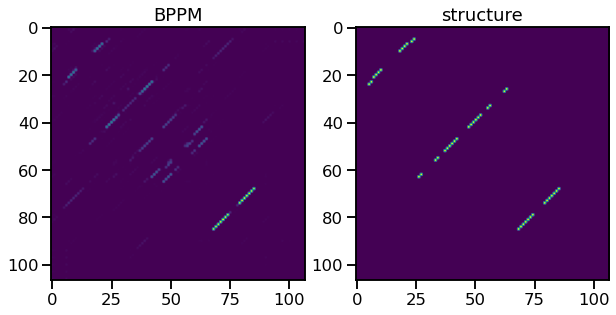

In [12]:
# Example
idx = 0
sample = train.loc[idx]

bppm = get_bppm(sample.id)
pm = get_structure(sample.structure)
plot_structures(bppm, pm)

We can notice that although the structure of bpps look similar to that of 'structure' feature, there are slight differences. The 'structure' feature is a binary representation, whereas the bpps have continuous values. It may be possible that the bpps contain more rich information than the 'structure'. If this is the case, we might want to include it as a feature for modeling somehow. 

One naive way to use bpps as a feature is to use its 1D representation by taking max along with its row or column (it does not matter which, as the structure is symmetric).

In [13]:
def get_bppm_feats(df, base_len=68):
    bppm = np.zeros((df['id'].nunique(), base_len))
    for i, id_ in tqdm(enumerate(df['id'].unique())):
        img = get_bppm(id_)
        maxv = np.max(img, axis=0)
        if len(maxv) >= base_len:
            bppm[i, :base_len] = maxv[:base_len]
        else:
            bppm[i, :len(maxv)] = maxv
    return bppm

bppm_train = get_bppm_feats(train)
bppm_test = get_bppm_feats(test, test['seq_length'].max())

2400it [00:05, 452.74it/s]
3634it [00:08, 452.42it/s]


Let's format train and test for an ordinary tabular modeling task. I used snippets from https://www.kaggle.com/t88take/openvaccine-simple-lgb-baseline. Thanks T88 for your great work.

In [14]:
def format_train(train, bppm_train, shifts=SHIFTS, shift_cols=seq_feats):
    train_data = []
    for mol_id in tqdm(train['id'].unique()):
        sample_data = train.loc[train['id'] == mol_id]
        sample_seq_length = sample_data.seq_length.values[0]

        for i in range(68):
            sample_dict = {'id' : sample_data['id'].values[0],
                           'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                          }
            for f in [f for f in train.columns.values.tolist() if f not in ['index', 'id', 'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',]]:
                sample_dict[f] = sample_data[f].values[0][i]
                
            for shift,col in itertools.product(shifts, shift_cols):
                if i - shift >= 0:
                    sample_dict['b'+str(shift)+'_'+col] = sample_data[col].values[0][i-shift]
                else:
                    sample_dict['b'+str(shift)+'_'+col] = -1

                if i + shift <= sample_seq_length - 1:
                    sample_dict['a'+str(shift)+'_'+col] = sample_data[col].values[0][i+shift]
                else:
                    sample_dict['a'+str(shift)+'_'+col] = -1
            
            sample_dict['bppm'] = bppm_train[train['id'].unique() == mol_id, i][0]

            train_data.append(sample_dict)
    train_data = pd.DataFrame(train_data)
    
    return train_data

train_data = format_train(train, bppm_train)
print(train_data.shape)
train_data.head()

100%|██████████| 2400/2400 [03:10<00:00, 12.60it/s]


(163200, 52)


,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,...,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type,b6_sequence,a6_sequence,b6_structure,a6_structure,b6_predicted_loop_type,a6_predicted_loop_type,bppm
0,id_001f94081,id_001f94081_0,G,.,E,0.1359,0.2613,0.2631,0.1501,0.2167,...,(,-1,S,-1,G,-1,(,-1,S,0.021786
1,id_001f94081,id_001f94081_1,G,.,E,0.2070,0.3842,0.2860,0.2750,0.3475,...,(,-1,S,-1,C,-1,(,-1,S,0.038653
2,id_001f94081,id_001f94081_2,A,.,E,0.1633,0.1372,0.0964,0.0947,0.1880,...,(,-1,S,-1,U,-1,(,-1,S,0.027590
3,id_001f94081,id_001f94081_3,A,.,E,0.1452,0.2531,0.1574,0.1866,0.2124,...,(,-1,S,-1,C,-1,(,-1,S,0.009471
4,id_001f94081,id_001f94081_4,A,.,E,0.1314,0.1798,0.1000,0.1369,0.1703,...,(,-1,S,-1,U,-1,(,-1,S,0.007029


In [15]:
def format_test(test, bppm_test, shifts=SHIFTS, shift_cols=seq_feats):
    test_data = []
    for mol_id in tqdm(test['id'].unique()):
        sample_data = test.loc[test['id'] == mol_id]
        sample_seq_length = sample_data.seq_length.values[0]
        for i in range(sample_seq_length):
            sample_dict = {'id' : sample_data['id'].values[0],
                           'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),}
            for f in seq_feats:
                sample_dict[f] = sample_data[f].values[0][i]

            for shift,col in itertools.product(shifts, shift_cols):
                if i - shift >= 0:
                    sample_dict['b'+str(shift)+'_'+col] = sample_data[col].values[0][i-shift]
                else:
                    sample_dict['b'+str(shift)+'_'+col] = -1

                if i + shift <= sample_seq_length - 1:
                    sample_dict['a'+str(shift)+'_'+col] = sample_data[col].values[0][i+shift]
                else:
                    sample_dict['a'+str(shift)+'_'+col] = -1
            
            sample_dict['bppm'] = bppm_test[test['id'].unique() == mol_id, i][0]

            test_data.append(sample_dict)
    test_data = pd.DataFrame(test_data)
    
    return test_data

test_data = format_test(test, bppm_test)
print(test_data.shape)
test_data.head()

100%|██████████| 3634/3634 [12:16<00:00,  4.93it/s]


(457953, 42)


,id,id_seqpos,sequence,structure,predicted_loop_type,b1_sequence,a1_sequence,b1_structure,a1_structure,b1_predicted_loop_type,...,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type,b6_sequence,a6_sequence,b6_structure,a6_structure,b6_predicted_loop_type,a6_predicted_loop_type,bppm
0,id_00073f8be,id_00073f8be_0,G,.,E,-1,G,-1,.,-1,...,.,-1,E,-1,G,-1,(,-1,S,0.007222
1,id_00073f8be,id_00073f8be_1,G,.,E,G,A,.,.,E,...,(,-1,S,-1,U,-1,(,-1,S,0.002258
2,id_00073f8be,id_00073f8be_2,A,.,E,G,A,.,.,E,...,(,-1,S,-1,A,-1,(,-1,S,0.001221
3,id_00073f8be,id_00073f8be_3,A,.,E,A,A,.,.,E,...,(,-1,S,-1,C,-1,(,-1,S,0.000381
4,id_00073f8be,id_00073f8be_4,A,.,E,A,A,.,.,E,...,(,-1,S,-1,G,-1,(,-1,S,0.002343


In [16]:
# label_encoding
sequence_encmap = {'A': 0, 'G' : 1, 'C' : 2, 'T': 3, 'U' : 4}
structure_encmap = {'.' : 0, '(' : 1, ')' : 2}
looptype_encmap = {'S':0, 'E':1, 'H':2, 'I':3, 'X':4, 'M':5, 'B':6}
enc_maps = [sequence_encmap, structure_encmap, looptype_encmap]

for t,m in zip(seq_feats, enc_maps):
    for c in [c for c in train_data.columns if t in c]:
        try:
            train_data[c] = train_data[c].replace(m)
            test_data[c] = test_data[c].replace(m)
        except:
            print('ERR: already numeric; ' + c)

In [17]:
print(train_data.shape)
train_data.head()

(163200, 52)


,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,...,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type,b6_sequence,a6_sequence,b6_structure,a6_structure,b6_predicted_loop_type,a6_predicted_loop_type,bppm
0,id_001f94081,id_001f94081_0,1,0,1,0.1359,0.2613,0.2631,0.1501,0.2167,...,1,-1,0,-1,1,-1,1,-1,0,0.021786
1,id_001f94081,id_001f94081_1,1,0,1,0.2070,0.3842,0.2860,0.2750,0.3475,...,1,-1,0,-1,2,-1,1,-1,0,0.038653
2,id_001f94081,id_001f94081_2,0,0,1,0.1633,0.1372,0.0964,0.0947,0.1880,...,1,-1,0,-1,4,-1,1,-1,0,0.027590
3,id_001f94081,id_001f94081_3,0,0,1,0.1452,0.2531,0.1574,0.1866,0.2124,...,1,-1,0,-1,2,-1,1,-1,0,0.009471
4,id_001f94081,id_001f94081_4,0,0,1,0.1314,0.1798,0.1000,0.1369,0.1703,...,1,-1,0,-1,4,-1,1,-1,0,0.007029


In [18]:
print(test_data.shape)
test_data.head()

(457953, 42)


,id,id_seqpos,sequence,structure,predicted_loop_type,b1_sequence,a1_sequence,b1_structure,a1_structure,b1_predicted_loop_type,...,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type,b6_sequence,a6_sequence,b6_structure,a6_structure,b6_predicted_loop_type,a6_predicted_loop_type,bppm
0,id_00073f8be,id_00073f8be_0,1,0,1,-1,1,-1,0,-1,...,0,-1,1,-1,1,-1,1,-1,0,0.007222
1,id_00073f8be,id_00073f8be_1,1,0,1,1,0,0,0,1,...,1,-1,0,-1,4,-1,1,-1,0,0.002258
2,id_00073f8be,id_00073f8be_2,0,0,1,1,0,0,0,1,...,1,-1,0,-1,0,-1,1,-1,0,0.001221
3,id_00073f8be,id_00073f8be_3,0,0,1,0,0,0,0,1,...,1,-1,0,-1,2,-1,1,-1,0,0.000381
4,id_00073f8be,id_00073f8be_4,0,0,1,0,0,0,0,1,...,1,-1,0,-1,1,-1,1,-1,0,0.002343


In [19]:
# save them for a rainy day
train_data.to_feather('train_fe.feather')
test_data.to_feather('test_fe.feather')
print('Saved!')

Saved!


# Fitting

In [20]:
not_use_cols = ['id', 'id_seqpos']
features = [c for c in test_data.columns if c not in not_use_cols]
print(features)

['sequence', 'structure', 'predicted_loop_type', 'b1_sequence', 'a1_sequence', 'b1_structure', 'a1_structure', 'b1_predicted_loop_type', 'a1_predicted_loop_type', 'b2_sequence', 'a2_sequence', 'b2_structure', 'a2_structure', 'b2_predicted_loop_type', 'a2_predicted_loop_type', 'b3_sequence', 'a3_sequence', 'b3_structure', 'a3_structure', 'b3_predicted_loop_type', 'a3_predicted_loop_type', 'b4_sequence', 'a4_sequence', 'b4_structure', 'a4_structure', 'b4_predicted_loop_type', 'a4_predicted_loop_type', 'b5_sequence', 'a5_sequence', 'b5_structure', 'a5_structure', 'b5_predicted_loop_type', 'a5_predicted_loop_type', 'b6_sequence', 'a6_sequence', 'b6_structure', 'a6_structure', 'b6_predicted_loop_type', 'a6_predicted_loop_type', 'bppm']


In [21]:
categoricals = []

In [22]:
mymodels = []
oof_df = pd.DataFrame(train_data.id_seqpos)
for target in target_cols:
    mymodel = RunModel(train_data, test_data, target, features, categoricals=categoricals,
                model="lgb", params={}, task="regression", n_splits=NFOLD, cv_method="GroupKFold", 
                group='id', target_encoding=False, seed=SEED, scaler=None)
    oof_df[target] = mymodel.oof
    submission[target] = mymodel.y_pred
    mymodels.append(mymodel)

##############################
Starting training model lgb for a regression task:
- train records: 163200, test records: 457953
- target column is reactivity
- 40 features with 0 categorical features
- target encoding: NOT Applied
- CV strategy : GroupKFold with 7 splits
- id as group parameter
- No scaler is used
##############################
Training until validation scores don't improve for 80 rounds
[100]	training's rmse: 0.65265	valid_1's rmse: 0.7322
[200]	training's rmse: 0.633421	valid_1's rmse: 0.713254
[300]	training's rmse: 0.625785	valid_1's rmse: 0.706032
[400]	training's rmse: 0.621004	valid_1's rmse: 0.70164
[500]	training's rmse: 0.61771	valid_1's rmse: 0.698278
[600]	training's rmse: 0.615225	valid_1's rmse: 0.696022
[700]	training's rmse: 0.613205	valid_1's rmse: 0.694507
[800]	training's rmse: 0.611447	valid_1's rmse: 0.693185
[900]	training's rmse: 0.60975	valid_1's rmse: 0.692063
[1000]	training's rmse: 0.608169	valid_1's rmse: 0.690942
[1100]	training's rmse: 0.6

# Feature importance

reactivity


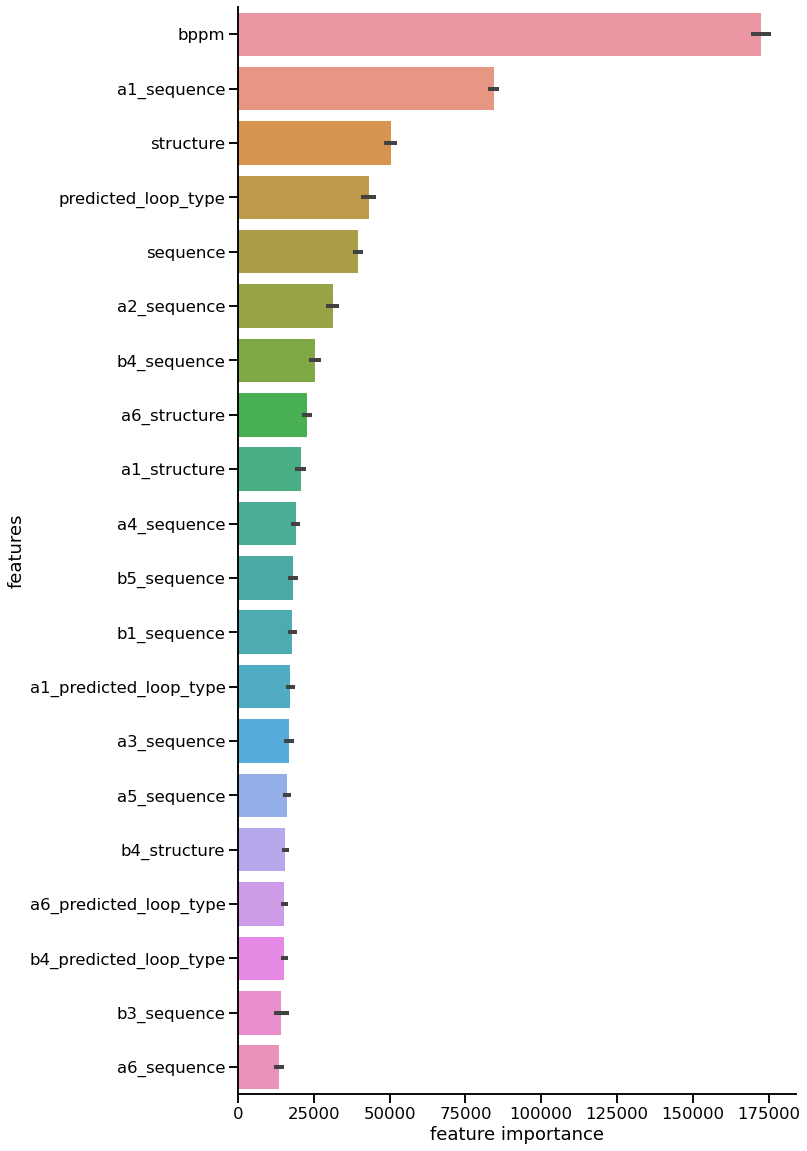

In [23]:
print(target_cols[0])
fi_df = mymodels[0].plot_feature_importance(rank_range=[1, 20])

deg_Mg_pH10


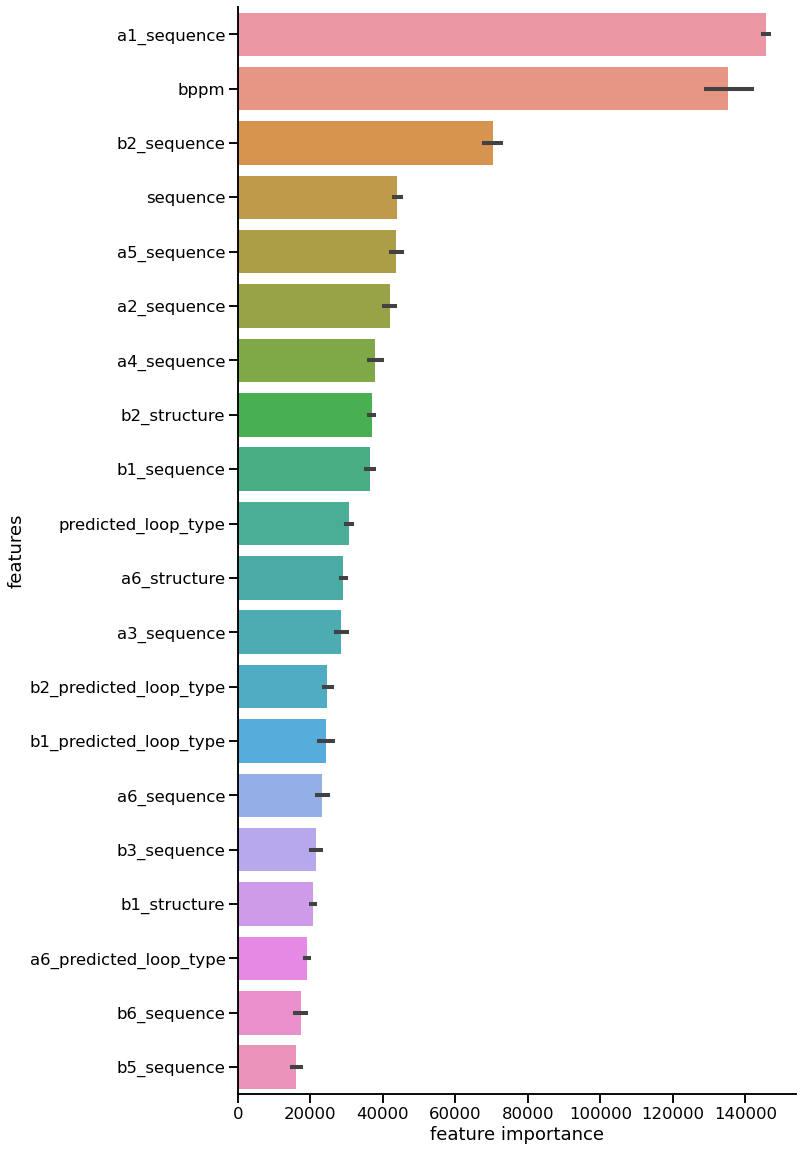

In [24]:
print(target_cols[1])
fi_df = mymodels[1].plot_feature_importance(rank_range=[1, 20])

deg_pH10


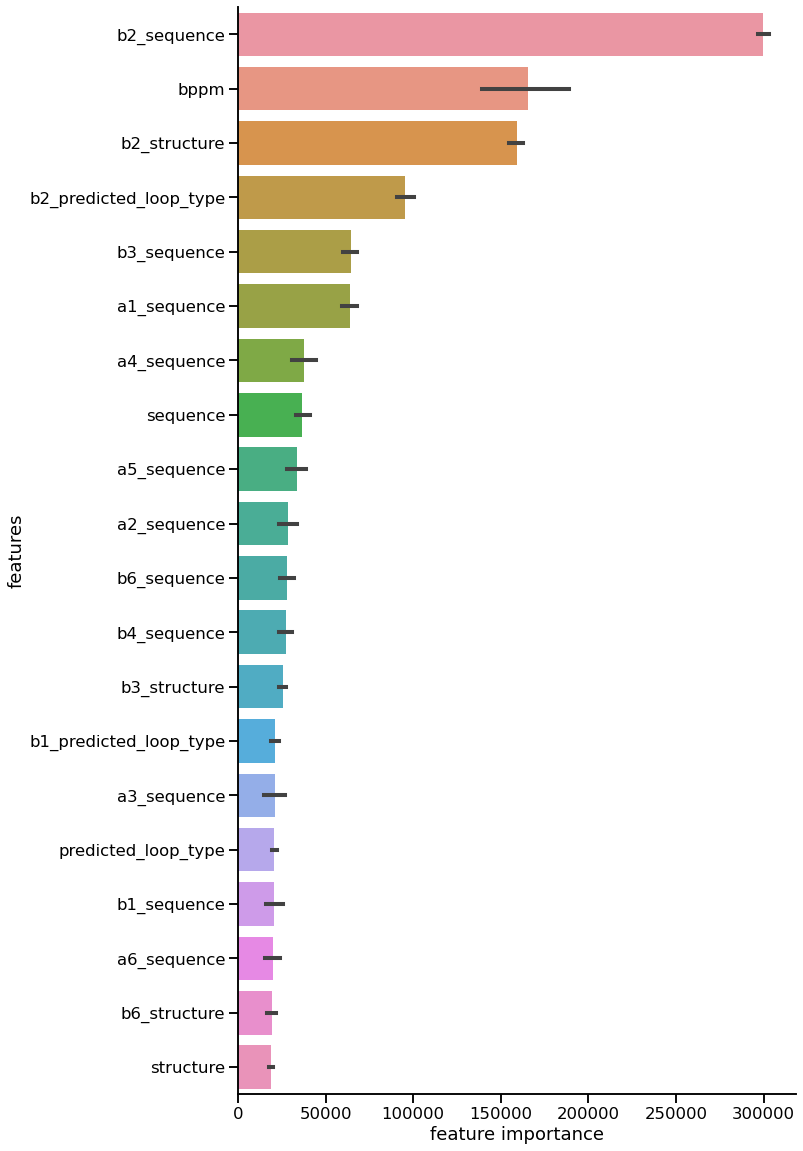

In [25]:
print(target_cols[2])
fi_df = mymodels[2].plot_feature_importance(rank_range=[1, 20])

deg_Mg_50C


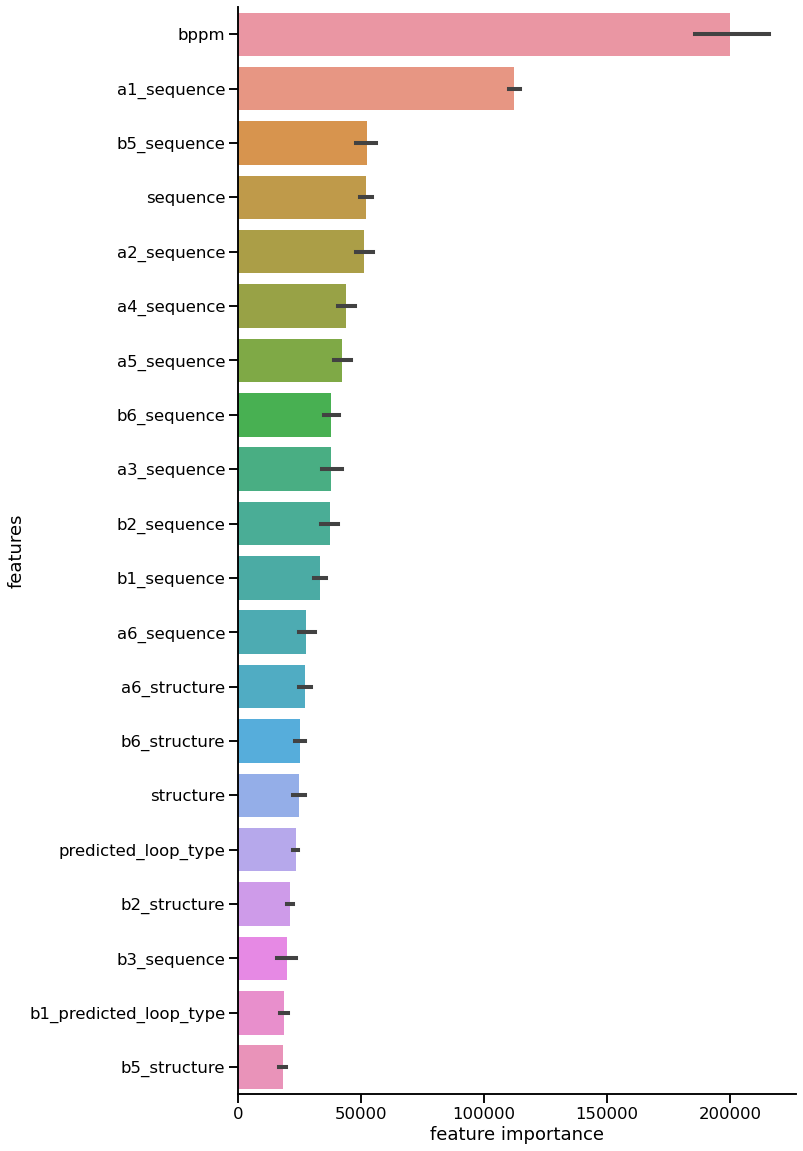

In [26]:
print(target_cols[3])
fi_df = mymodels[3].plot_feature_importance(rank_range=[1, 20])

deg_50C


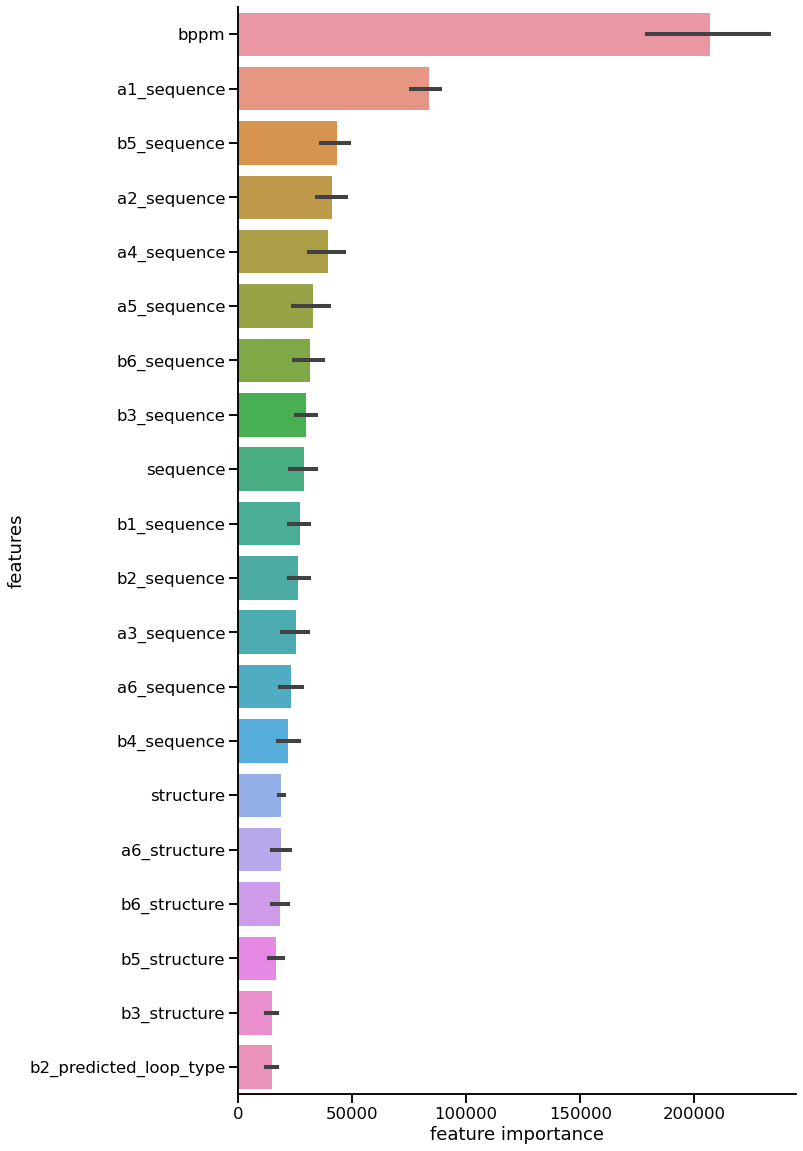

In [27]:
print(target_cols[4])
fi_df = mymodels[4].plot_feature_importance(rank_range=[1, 20])

Surprise, surprise! Bpps seem to contain very rich information about our targets!

# OOF, Submit files

In [28]:
oof_df.to_csv('oof_df.csv', index=False)
submission.to_csv('submission.csv', index=False)
print('saved!')

saved!


The score is also not super bad given that this is a simple LGB model. This approach can be used for ensemble along with other modeling approaches such as RNN (Recurrent Neural Network) and GNN (Graphical Neural Network).